In [2]:
import matplotlib.pyplot as plt
import legendstyles

In [3]:
plt.style.use(legendstyles.LEGEND)

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import os
import datetime
import pandas   as pd
import numpy    as np

import matplotlib.pyplot as plt
import matplotlib.dates  as mdates

from datetime   import datetime, timezone
from legendmeta import LegendMetadata

lmeta = LegendMetadata('/Users/romoluque_c/Repositories/legend-metadata-ref-v2.1.0/')

from h5glance import H5Glance
from lgdo     import LH5Store

#import lgdo.lh5_store as lh5
import lgdo.lh5 as lh5

In [6]:
colors    = plt.rcParams['axes.prop_cycle'].by_key()['color']
data_path = '/Users/romoluque_c/LEGEND/Event_rate_analysis_after_TAUP/skm_data/ref-v2.1.0/'

In [7]:
legend_colors = {'legend_grey':   '#CCCCCC', 'legend_blue':      '#07A9FF', 'legend_darkblue': '#1A2A5B',
                 'legend_orange': '#FF9E21', 'legend_green':     '#53BF0F', 'legend_violet':   '#BB19BF',
                 'legend_gold':   '#806318', 'legend_darkgreen': '#1A4D20', 'legend_purple':   '#66283A',
                 'black':         '#000000', 'red':              '#B9123E', 'yellow':          '#ffc74e',
                 'green':         '#39a974', 'purple':           '#8A1859', 'silver':          '#BFC2C7',
                 'salmon':        '#FFB0A8', 'violet':           '#B580CA', 'darkblue':        '#203769',
                 'grey':          '#909090', 'gray':             '#909090', '1sigma_green':    '#83C369',
                 '2sigma_yellow': '#FDED95', 'mint':             '#85F7C2', 'forestgreen':     '#105D20',
                 'orange':        '#E77D4D', 'darkred':          '#9D0008', 'sand':            '#EDDAB7',
                 'lightgrey':     '#DCDCDC', 'lightgray':        '#DCDCDC', 'jet':             '#393939',
                 'teal':          '#149A9A'}

In [8]:
skm_files = [file for file in os.listdir(data_path) if file.endswith("skm.lh5")]

def sort_key(filename):
    parts  = filename.split('-')
    period = parts[1]  # Extract period (p03, p04, etc.)
    run    = parts[2]  # Extract run (r000, r001, etc.)
    return (period, run)

sorted_skm_files = sorted(skm_files, key=sort_key)

In [9]:
df_list = []
for file in sorted_skm_files:
    df_temp = lh5.read_as("/skm", data_path + file, "pd")
    period, run = sort_key(file)
    df_temp['period'] = int(period[1:])
    df_temp['run'   ] = int(run   [1:])
    df_list.append(df_temp)
df_skm = pd.concat(df_list, ignore_index=True)

df_skm['trigger_timestamp'] = pd.to_datetime(df_skm['trigger_timestamp'], unit='s') ## Required to compute the event rates!!

In [10]:
timestamp = "20230311T235840Z"
chmap     = lmeta.hardware.configuration.channelmaps.on(timestamp=timestamp)
diodes    = lmeta.hardware.detectors.germanium.diodes
geds      = chmap.map("system", unique=False)["geds"]
geds      = geds.map("daq.rawid")

ged_names     = {}
ged_types     = {}
ged_masses    = {}
ged_strings   = {}
ged_positions = {}

for rawid, val in geds.items():
    ged_names    [rawid] = val.name
    ged_types    [rawid] = diodes[val.name]['type']
    ged_masses   [rawid] = diodes[val.name]['production']['mass_in_g']
    ged_strings  [rawid] = chmap [val.name].location['string']#[]
    ged_positions[rawid] = chmap [val.name].location['position']#[]

df_skm['geds_name']     = df_skm['geds_rawid'].map(ged_names)
df_skm['geds_type']     = df_skm['geds_rawid'].map(ged_types)
df_skm['geds_mass']     = df_skm['geds_rawid'].map(ged_masses)
df_skm['geds_string']   = df_skm['geds_rawid'].map(ged_strings)
df_skm['geds_position'] = df_skm['geds_rawid'].map(ged_positions)

In [11]:
## Remove muon events and P00748A from p06 and p07 (ringing)

mask_muons   =  df_skm.coincident_muon==True
mask_ringing = (df_skm.geds_name=='P00748A') & (df_skm.period==6) & (df_skm.period==7)

df_skm = df_skm[~(mask_muons & mask_ringing)]

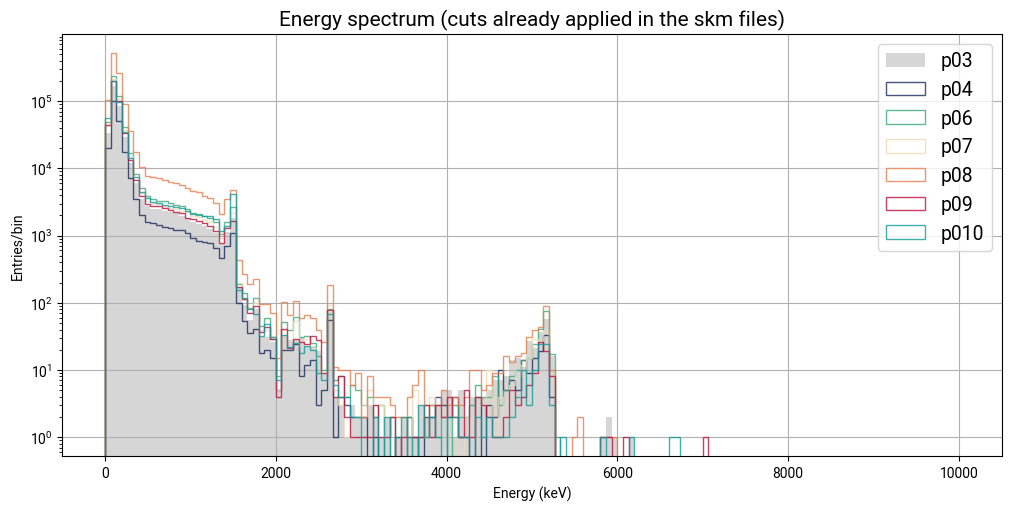

In [12]:
colors_per = ['legend_grey', 'legend_darkblue', 'green', 'sand', 'orange', 'red', 'teal']

fig, ax = plt.subplots(figsize=(10, 5))
for period, col in zip(df_skm.period.unique(), colors_per):
    df_skm_per = df_skm[df_skm.period==period]
    if period ==3:
        df_skm_per.geds_energy.hist(bins=150, range=(0, 10000), log=True, alpha=0.8, label=f'p0{period}', color=legend_colors[col])
    else:
        df_skm_per.geds_energy.hist(bins=150, range=(0, 10000), log=True, alpha=0.8, label=f'p0{period}', histtype='step', color=legend_colors[col])
plt.title('Energy spectrum (cuts already applied in the skm files)', fontsize=15)
plt.xlabel('Energy (keV)')
plt.ylabel('Entries/bin')
plt.legend(loc=1, fontsize=14);

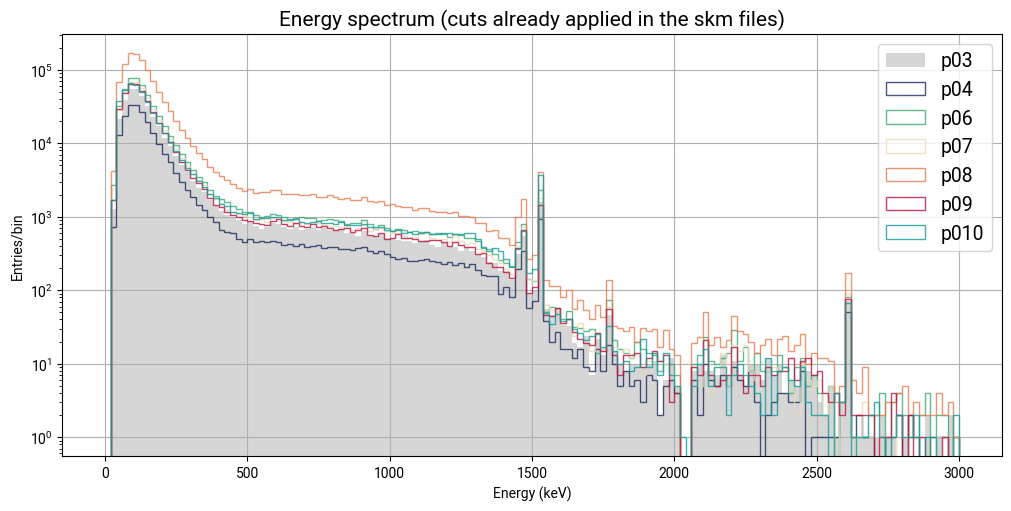

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
for period, col in zip(df_skm.period.unique(), colors_per):
    df_skm_per = df_skm[df_skm.period==period]
    if period ==3:
        df_skm_per.geds_energy.hist(bins=150, range=(0, 3000), log=True, alpha=0.8, label=f'p0{period}', color=legend_colors[col])
    else:
        df_skm_per.geds_energy.hist(bins=150, range=(0, 3000), log=True, alpha=0.8, label=f'p0{period}', histtype='step', color=legend_colors[col])
plt.title('Energy spectrum (cuts already applied in the skm files)', fontsize=15)
plt.xlabel('Energy (keV)')
plt.ylabel('Entries/bin')
plt.legend(loc=1, fontsize=14);

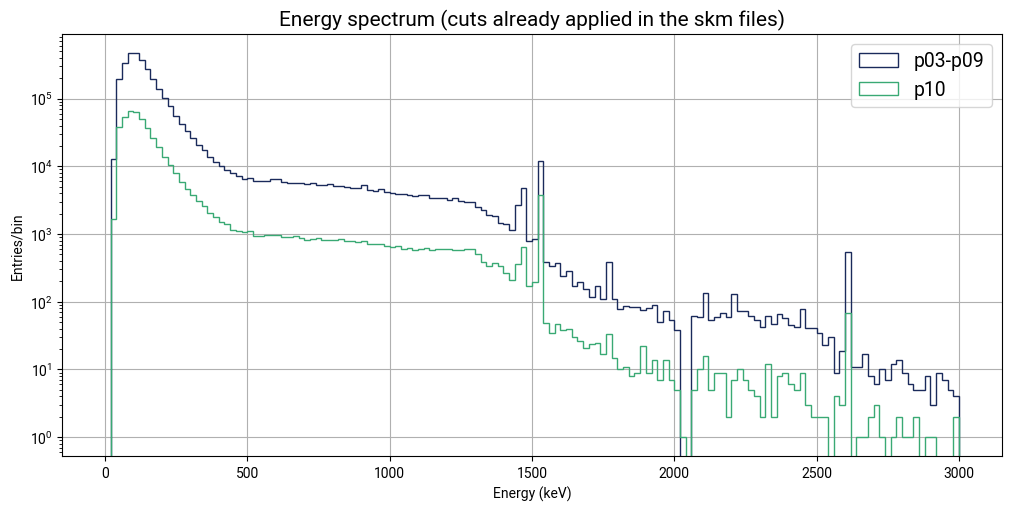

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
sel_p10 = df_skm.period==10
df_skm_p03_p09 = df_skm[~sel_p10]
df_skm_p10     = df_skm[ sel_p10]
df_skm_p03_p09.geds_energy.hist(bins=150, range=(0, 3000), log=True, label=f'p03-p09', histtype='step', color=legend_colors[colors_per[1]])
df_skm_p10    .geds_energy.hist(bins=150, range=(0, 3000), log=True, label=f'p10',     histtype='step', color=legend_colors[colors_per[2]])
plt.title('Energy spectrum (cuts already applied in the skm files)', fontsize=15)
plt.xlabel('Energy (keV)')
plt.ylabel('Entries/bin')
plt.legend(loc=1, fontsize=14);

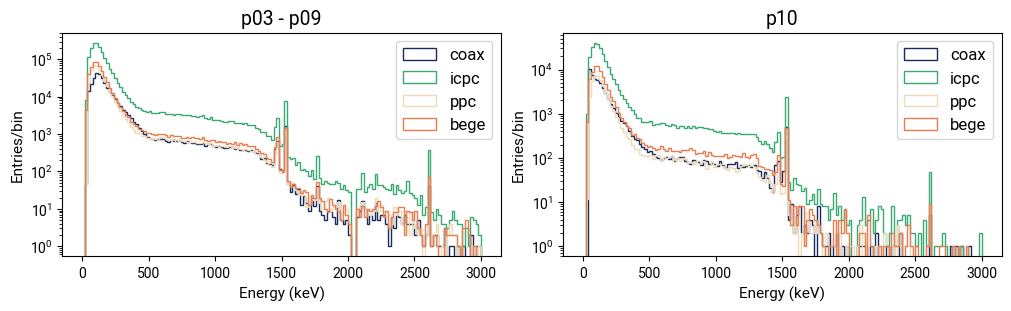

In [15]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3))
sel_p10 = df_skm.period==10
df_skm_p03_p09 = df_skm[~sel_p10]
df_skm_p10     = df_skm[ sel_p10]

for det_type, col in zip(df_skm.geds_type.unique(), colors_per[1:]):
    ax0.hist(df_skm_p03_p09[df_skm_p03_p09.geds_type==det_type].geds_energy, bins=150, range=(0, 3000), log=True, label=det_type, histtype='step', color=legend_colors[col])
    ax1.hist(df_skm_p10    [df_skm_p10    .geds_type==det_type].geds_energy, bins=150, range=(0, 3000), log=True, label=det_type, histtype='step', color=legend_colors[col])
#ax0.set_title('p03 - p09', fontsize=15)
#ax1.set_title('p10',       fontsize=15)
#ax0.set_xlabel('Energy (keV)')
#ax0.set_ylabel('Entries/bin')
#ax1.set_xlabel('Energy (keV)')
#ax1.set_ylabel('Entries/bin')
for ax, tit in zip([ax0, ax1], ['p03 - p09', 'p10']):
    ax.set_title(tit, fontsize=14)
    ax.set_xlabel('Energy (keV)', fontsize=11)
    ax.set_ylabel('Entries/bin',  fontsize=11)
    ax.legend(loc=1, fontsize=12);

## Toby's files

In [16]:
import uproot

In [17]:
#!pip install hist
#!pip install mplhep

In [18]:
from hist import Hist

In [19]:
hist_files = '/Users/romoluque_c/LEGEND/2nbb_distortions/data_bckg_model/histograms.root'
hfile      = uproot.open(hist_files)

In [21]:
hfile.keys()

['l200a_neutrino24_fix_v2_1_0_a_cat_a_e1;1',
 'l200a_neutrino24_fix_v2_1_0_a_cat_a_e1/originals;1',
 'l200a_neutrino24_fix_v2_1_0_a_cat_a_e1/originals/fitted_data;1',
 'l200a_neutrino24_fix_v2_1_0_a_cat_a_e1/originals/Nvbb_icpc;1',
 'l200a_neutrino24_fix_v2_1_0_a_cat_a_e1/originals/Ac228_birds_nest;1',
 'l200a_neutrino24_fix_v2_1_0_a_cat_a_e1/originals/Ac228_cables;1',
 'l200a_neutrino24_fix_v2_1_0_a_cat_a_e1/originals/Ac228_fiber_shroud;1',
 'l200a_neutrino24_fix_v2_1_0_a_cat_a_e1/originals/Ac228_front_end_electronics;1',
 'l200a_neutrino24_fix_v2_1_0_a_cat_a_e1/originals/Ac228_hpge_insulators;1',
 'l200a_neutrino24_fix_v2_1_0_a_cat_a_e1/originals/Ac228_hpge_support_copper;1',
 'l200a_neutrino24_fix_v2_1_0_a_cat_a_e1/originals/Ac228_mini_shroud;1',
 'l200a_neutrino24_fix_v2_1_0_a_cat_a_e1/originals/Ac228_pen_plates;1',
 'l200a_neutrino24_fix_v2_1_0_a_cat_a_e1/originals/Ac228_wls_reflector;1',
 'l200a_neutrino24_fix_v2_1_0_a_cat_a_e1/originals/Ar39_homogeneous;1',
 'l200a_neutrino24_fi

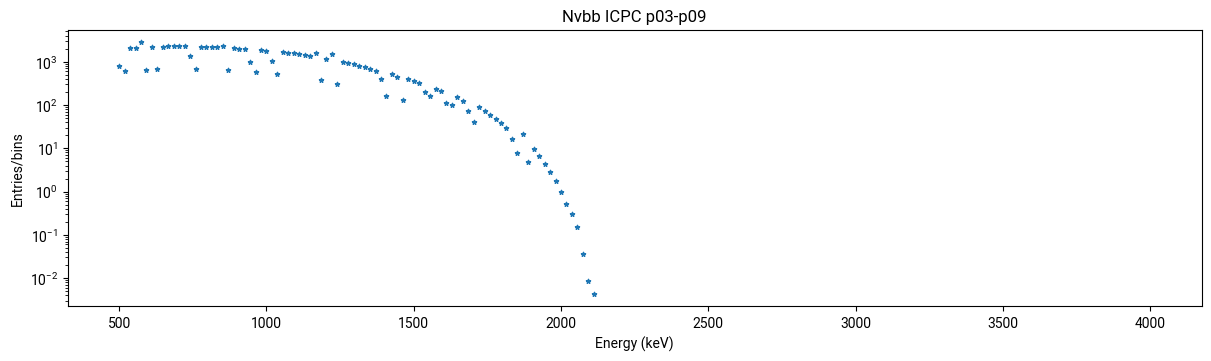

In [22]:
icpc_hist_v = hfile['l200a_neutrino24_fix_v2_1_0_a_icpc/Nvbb_icpc'].values()
icpc_hist_b = np.linspace(500, 4000, len(icpc_hist_v))

plt.scatter(icpc_hist_b, icpc_hist_v, marker='*', s=10)
plt.xlabel('Energy (keV)')
plt.ylabel('Entries/bins')
plt.title('Nvbb ICPC p03-p09')
plt.yscale('log')
plt.show()

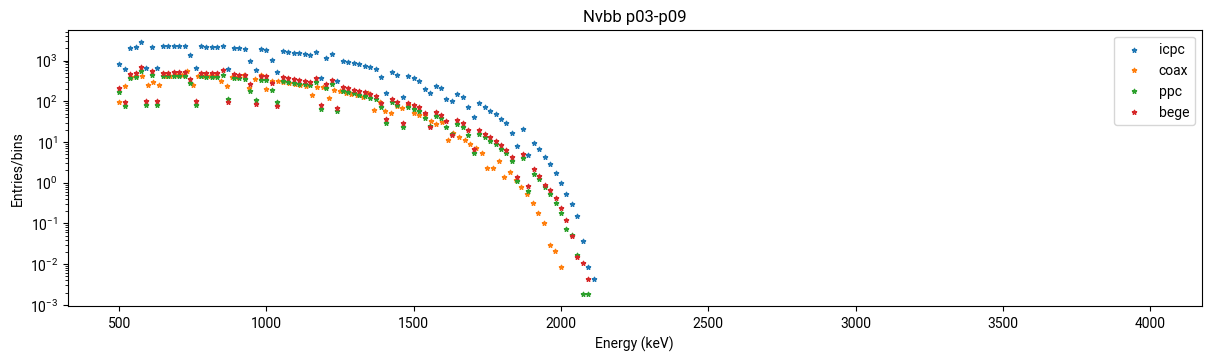

In [25]:
for det_type in ['icpc', 'coax', 'ppc', 'bege']:
    hist_v = hfile[f'l200a_neutrino24_fix_v2_1_0_a_{det_type}/Nvbb_{det_type}'].values()
    hist_b = np.linspace(500, 4000, len(hist_v))
    plt.scatter(hist_b, hist_v, marker='*', s=10, label=det_type)
plt.xlabel('Energy (keV)')
plt.ylabel('Entries/bins')
plt.title('Nvbb p03-p09')
plt.yscale('log')
plt.legend()
plt.show()

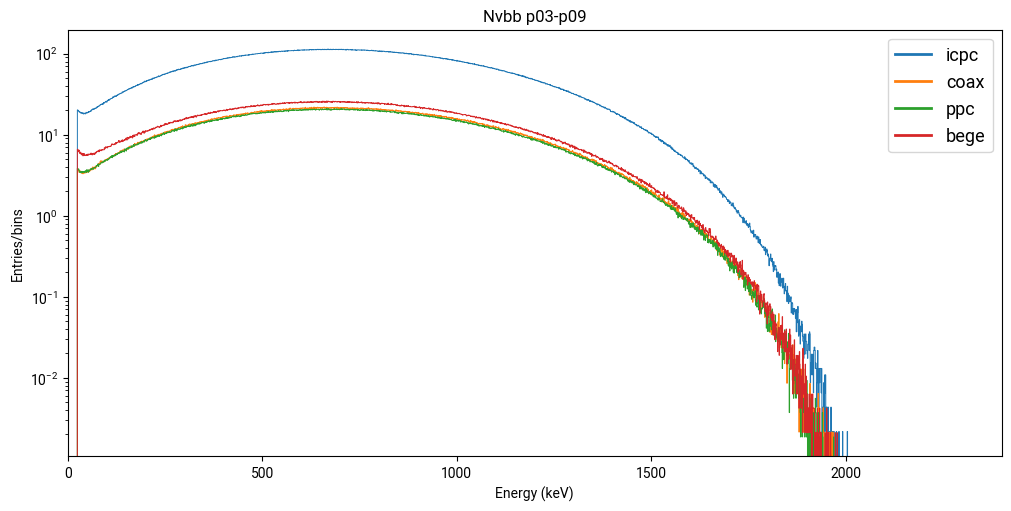

In [29]:
style = {"yerr": False,
         "lw":   0.7}

fig, ax = plt.subplots(figsize=(10, 5))
for det_type in ['icpc', 'coax', 'ppc', 'bege']:
    det_hist = hfile[f'l200a_neutrino24_fix_v2_1_0_a_{det_type}/originals/Nvbb_{det_type}'].to_hist()
    det_hist.plot(ax=ax, **style, label=det_type)
plt.xlabel('Energy (keV)')
plt.ylabel('Entries/bins')
plt.title('Nvbb p03-p09')
plt.xlim(0, 2400)
plt.yscale('log')
leg = plt.legend(fontsize=13)
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

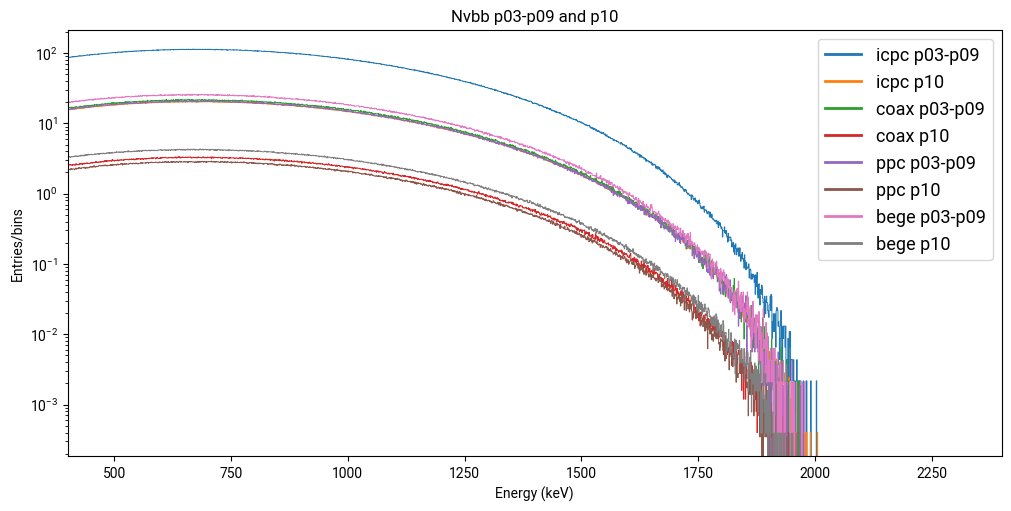

In [30]:
style = {"yerr": False,
         "lw":   0.7}

fig, ax = plt.subplots(figsize=(10, 5))
for det_type in ['icpc', 'coax', 'ppc', 'bege']:
    det_hist_p09 = hfile[f'l200a_neutrino24_fix_v2_1_0_a_{det_type}/originals/Nvbb_{det_type}'].to_hist()
    det_hist_p09.plot(ax=ax, **style, label=det_type+' p03-p09')
    det_hist_p10 = hfile[f'l200a_neutrino24_p10_fix_v2_1_0_a_{det_type}/originals/Nvbb_{det_type}'].to_hist()
    det_hist_p10.plot(ax=ax, **style, label=det_type+' p10')
plt.xlabel('Energy (keV)')
plt.ylabel('Entries/bins')
plt.title('Nvbb p03-p09 and p10')
plt.xlim(400, 2400)
plt.yscale('log')
leg = plt.legend(fontsize=13)
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

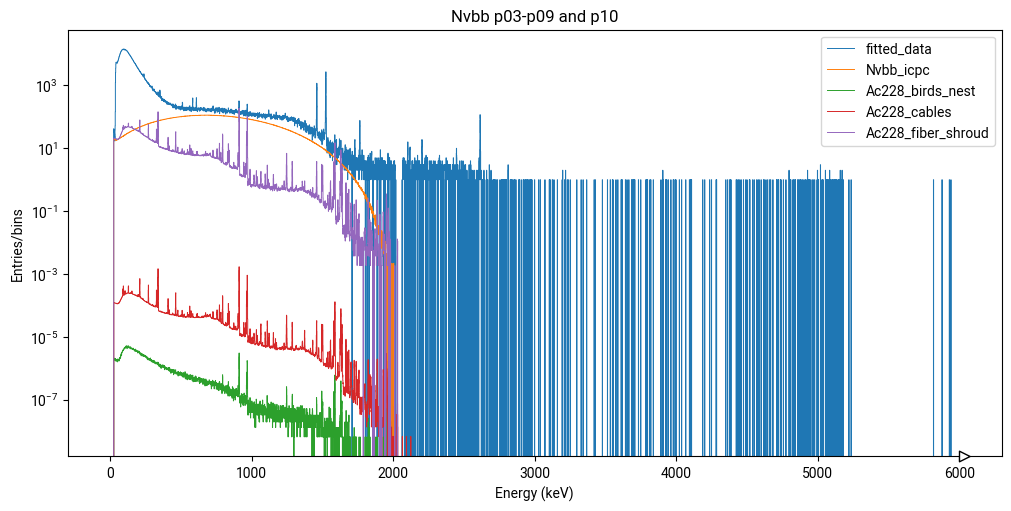

In [44]:
fig, ax = plt.subplots(figsize=(10, 5))
for key in [key for key in hfile.keys() if key.startswith('l200a_neutrino24_fix_v2_1_0_a_icpc/origi')][1:6]:
    icpc_sel_hist = hfile[key].to_hist()
    key_label = key.split('/')[-1][:-2]
    icpc_sel_hist.plot(ax=ax, **style, label=f'{key_label}')
plt.xlabel('Energy (keV)')
plt.ylabel('Entries/bins')
plt.title('Nvbb p03-p09 and p10')
plt.yscale('log')
plt.legend()
plt.show()

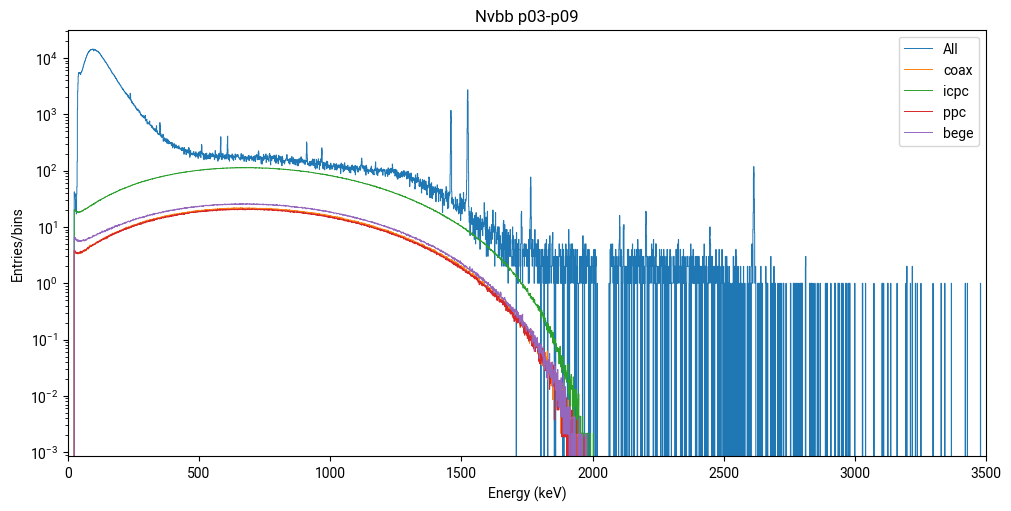

In [45]:
fig, ax = plt.subplots(figsize=(10, 5))
hist_all = hfile['l200a_neutrino24_fix_v2_1_0_a_icpc/originals/fitted_data;1'].to_hist()
hist_all.plot(ax=ax, **style, label=f'All')
for det_type, col in zip(df_skm.geds_type.unique(), colors_per[1:]):
    det_hist = hfile[f'l200a_neutrino24_fix_v2_1_0_a_{det_type}/originals/Nvbb_{det_type};1'].to_hist()
    det_hist.plot(ax=ax, **style, label=f'{det_type}')
plt.xlim(0, 3500)
plt.xlabel('Energy (keV)')
plt.ylabel('Entries/bins')
plt.title('Nvbb p03-p09')
plt.yscale('log')
plt.legend()
plt.show()

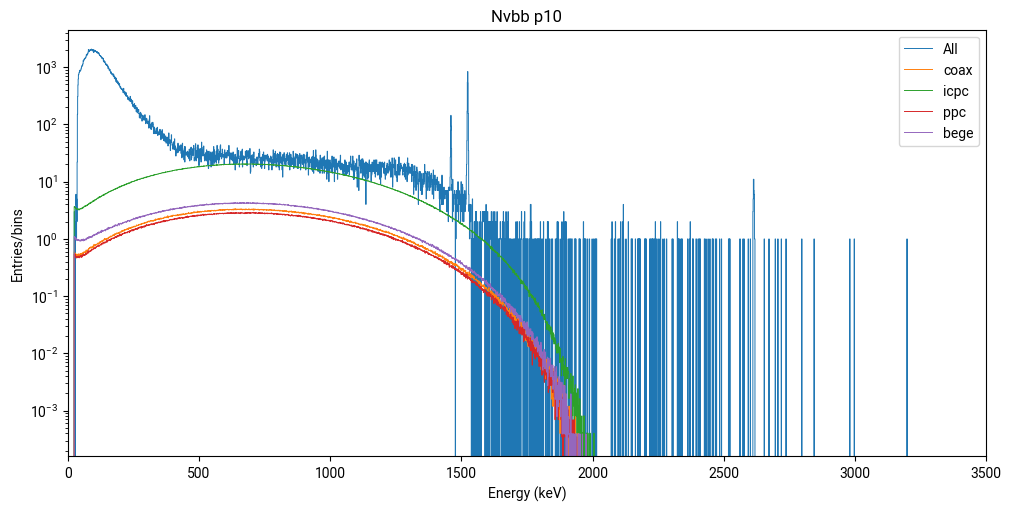

In [46]:
fig, ax = plt.subplots(figsize=(10, 5))
hist_all = hfile['l200a_neutrino24_p10_fix_v2_1_0_a_icpc/originals/fitted_data;1'].to_hist()
hist_all.plot(ax=ax, **style, label=f'All')
for det_type, col in zip(df_skm.geds_type.unique(), colors_per[1:]):
    det_hist = hfile[f'l200a_neutrino24_p10_fix_v2_1_0_a_{det_type}/originals/Nvbb_{det_type};1'].to_hist()
    det_hist.plot(ax=ax, **style, label=f'{det_type}')
plt.xlim(0, 3500)
plt.xlabel('Energy (keV)')
plt.ylabel('Entries/bins')
plt.title('Nvbb p10')
plt.yscale('log')
plt.legend()
plt.show()

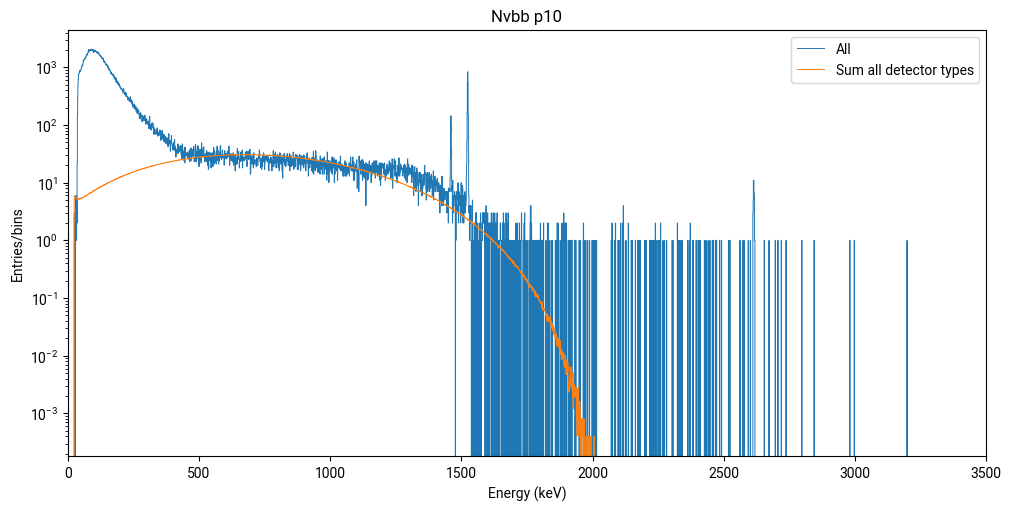

In [47]:
fig, ax = plt.subplots(figsize=(10, 5))
hist_all = hfile['l200a_neutrino24_p10_fix_v2_1_0_a_icpc/originals/fitted_data;1'].to_hist()
hist_all.plot(ax=ax, **style, label=f'All')
combined_hist = None
for det_type, col in zip(df_skm.geds_type.unique(), colors_per[1:]):
    det_hist = hfile[f'l200a_neutrino24_p10_fix_v2_1_0_a_{det_type}/originals/Nvbb_{det_type};1'].to_hist()
    if combined_hist == None:
        combined_hist = det_hist.copy()
    else:
        combined_hist += det_hist
combined_hist.plot(ax=ax, **style, label=f'Sum all detector types')
plt.xlim(0, 3500)
plt.xlabel('Energy (keV)')
plt.ylabel('Entries/bins')
plt.title('Nvbb p10')
plt.yscale('log')
plt.legend()
plt.show()

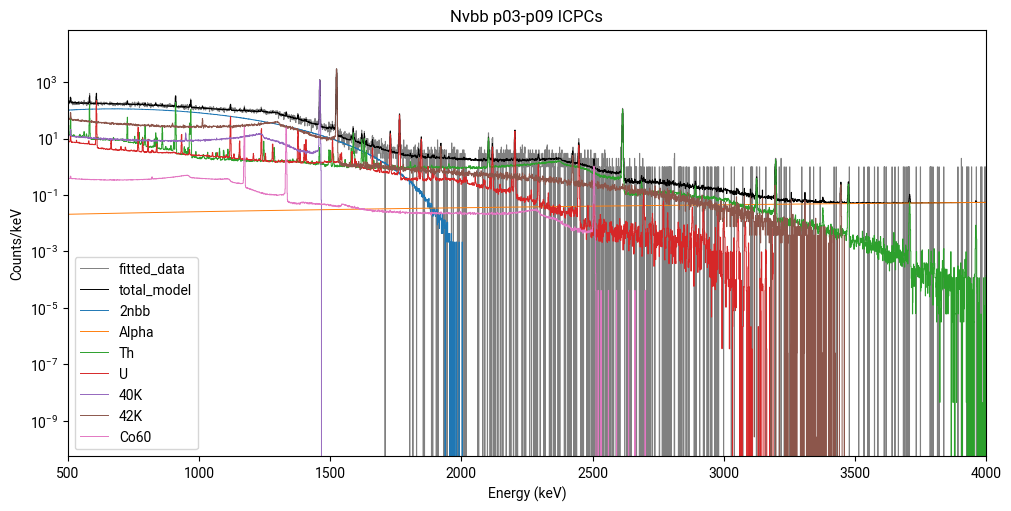

In [48]:
## All bckgs for ICPCs

fig, ax    = plt.subplots(figsize=(10, 5))
a_chain    = None
Th_chain   = None
U_chain    = None
K40_chain  = None
K42_chain  = None
Co60_chain = None
for key in [key for key in hfile.keys() if key.startswith('l200a_neutrino24_fix_v2_1_0_a_icpc/origi')][1:]:
    sel_hist = hfile[key].to_hist()
    key_label = key.split('/')[-1][:-2]
    if key_label.startswith('alpha_icpc'):
        if a_chain == None:
            a_chain = sel_hist.copy()
        else:
            a_chain += sel_hist
    elif key_label.startswith('Ac228') or key_label.startswith('Bi212Tl208'):
        if Th_chain == None:
            Th_chain = sel_hist.copy()
        else:
            Th_chain += sel_hist
    elif key_label.startswith('Pb214Bi214'):
        if U_chain == None:
            U_chain = sel_hist.copy()
        else:
            U_chain += sel_hist
    elif key_label.startswith('K40'):
        if K40_chain == None:
            K40_chain = sel_hist.copy()
        else:
            K40_chain += sel_hist
    elif key_label.startswith('K42'):
        if K42_chain == None:
            K42_chain = sel_hist.copy()
        else:
            K42_chain += sel_hist
    elif key_label.startswith('Co60'):
        if Co60_chain == None:
            Co60_chain = sel_hist.copy()
        else:
            Co60_chain += sel_hist
hist_all  = hfile['l200a_neutrino24_fix_v2_1_0_a_icpc/originals/fitted_data;1'].to_hist()
model_all = hfile['l200a_neutrino24_fix_v2_1_0_a_icpc/originals/total_model;1'].to_hist()
Nvbb      = hfile['l200a_neutrino24_fix_v2_1_0_a_icpc/originals/Nvbb_icpc;1']  .to_hist()

hist_all  .plot(ax=ax, **style, label=f'fitted_data', color='grey')
model_all .plot(ax=ax, **style, label=f'total_model', color='k')
Nvbb      .plot(ax=ax, **style, label=f'2nbb')
a_chain   .plot(ax=ax, **style, label=f'Alpha')
Th_chain  .plot(ax=ax, **style, label=f'Th')
U_chain   .plot(ax=ax, **style, label=f'U')
K40_chain .plot(ax=ax, **style, label=f'40K')
K42_chain .plot(ax=ax, **style, label=f'42K')
Co60_chain.plot(ax=ax, **style, label=f'Co60')

plt.xlim(500, 4000)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts/keV')
plt.title('Nvbb p03-p09 ICPCs')
plt.yscale('log')
plt.legend()
plt.show()

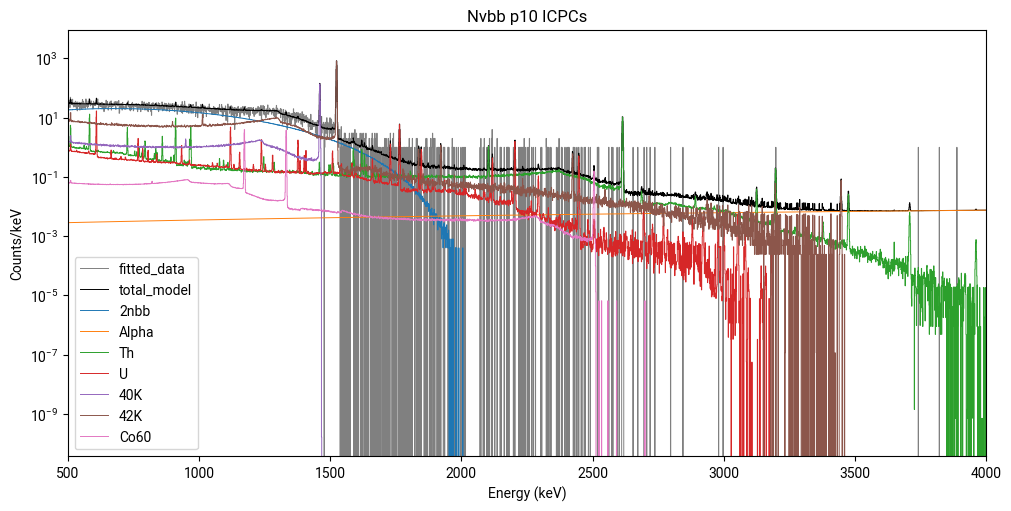

In [49]:
## All bckgs for ICPCs

fig, ax    = plt.subplots(figsize=(10, 5))
a_chain    = None
Th_chain   = None
U_chain    = None
K40_chain  = None
K42_chain  = None
Co60_chain = None
for key in [key for key in hfile.keys() if key.startswith('l200a_neutrino24_p10_fix_v2_1_0_a_icpc/origi')][1:]:
    sel_hist = hfile[key].to_hist()
    key_label = key.split('/')[-1][:-2]
    if key_label.startswith('alpha_icpc'):
        if a_chain == None:
            a_chain = sel_hist.copy()
        else:
            a_chain += sel_hist
    elif key_label.startswith('Ac228') or key_label.startswith('Bi212Tl208'):
        if Th_chain == None:
            Th_chain = sel_hist.copy()
        else:
            Th_chain += sel_hist
    elif key_label.startswith('Pb214Bi214'):
        if U_chain == None:
            U_chain = sel_hist.copy()
        else:
            U_chain += sel_hist
    elif key_label.startswith('K40'):
        if K40_chain == None:
            K40_chain = sel_hist.copy()
        else:
            K40_chain += sel_hist
    elif key_label.startswith('K42'):
        if K42_chain == None:
            K42_chain = sel_hist.copy()
        else:
            K42_chain += sel_hist
    elif key_label.startswith('Co60'):
        if Co60_chain == None:
            Co60_chain = sel_hist.copy()
        else:
            Co60_chain += sel_hist
hist_all  = hfile['l200a_neutrino24_p10_fix_v2_1_0_a_icpc/originals/fitted_data;1'].to_hist()
model_all = hfile['l200a_neutrino24_p10_fix_v2_1_0_a_icpc/originals/total_model;1'].to_hist()
Nvbb      = hfile['l200a_neutrino24_p10_fix_v2_1_0_a_icpc/originals/Nvbb_icpc;1']  .to_hist()

hist_all  .plot(ax=ax, **style, label=f'fitted_data', color='grey')
model_all .plot(ax=ax, **style, label=f'total_model', color='k')
Nvbb      .plot(ax=ax, **style, label=f'2nbb')
a_chain   .plot(ax=ax, **style, label=f'Alpha')
Th_chain  .plot(ax=ax, **style, label=f'Th')
U_chain   .plot(ax=ax, **style, label=f'U')
K40_chain .plot(ax=ax, **style, label=f'40K')
K42_chain .plot(ax=ax, **style, label=f'42K')
Co60_chain.plot(ax=ax, **style, label=f'Co60')

plt.xlim(500, 4000)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts/keV')
plt.title('Nvbb p10 ICPCs')
plt.yscale('log')
plt.legend()
plt.show()

## Try to rebin to 10 keV

In [50]:
def rebinned_hist_vals(hist, rebin_factor=10):
    counts    = hist.values()
    bin_edges = hist.axes[0].edges
    
    counts_rebinned    = np.add.reduceat(counts, np.arange(0, len(counts), rebin_factor))
    bin_edges_rebinned = bin_edges[::rebin_factor]

    return counts_rebinned, bin_edges_rebinned

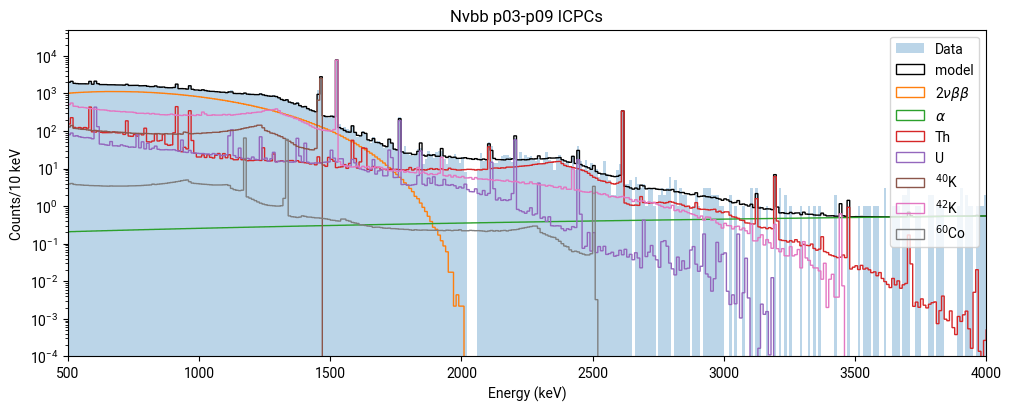

In [51]:
## All bckgs for ICPCs

a_chain    = None
Th_chain   = None
U_chain    = None
K40_chain  = None
K42_chain  = None
Co60_chain = None
for key in [key for key in hfile.keys() if key.startswith('l200a_neutrino24_fix_v2_1_0_a_icpc/origi')][1:]:
    sel_hist = hfile[key].to_hist()
    key_label = key.split('/')[-1][:-2]
    if key_label.startswith('alpha_icpc'):
        if a_chain == None:
            a_chain = sel_hist.copy()
        else:
            a_chain += sel_hist
    elif key_label.startswith('Ac228') or key_label.startswith('Bi212Tl208'):
        if Th_chain == None:
            Th_chain = sel_hist.copy()
        else:
            Th_chain += sel_hist
    elif key_label.startswith('Pb214Bi214'):
        if U_chain == None:
            U_chain = sel_hist.copy()
        else:
            U_chain += sel_hist
    elif key_label.startswith('K40'):
        if K40_chain == None:
            K40_chain = sel_hist.copy()
        else:
            K40_chain += sel_hist
    elif key_label.startswith('K42'):
        if K42_chain == None:
            K42_chain = sel_hist.copy()
        else:
            K42_chain += sel_hist
    elif key_label.startswith('Co60'):
        if Co60_chain == None:
            Co60_chain = sel_hist.copy()
        else:
            Co60_chain += sel_hist
hist_all  = hfile['l200a_neutrino24_fix_v2_1_0_a_icpc/originals/fitted_data;1'].to_hist()
model_all = hfile['l200a_neutrino24_fix_v2_1_0_a_icpc/originals/total_model;1'].to_hist()
Nvbb      = hfile['l200a_neutrino24_fix_v2_1_0_a_icpc/originals/Nvbb_icpc;1']  .to_hist()

c_rebin_fitted_data, be_rebin_fitted_data = rebinned_hist_vals(hist_all)
c_rebin_model      , be_rebin_model       = rebinned_hist_vals(model_all)
c_rebin_Nvbb       , be_rebin_Nvbb        = rebinned_hist_vals(Nvbb)
c_rebin_a_chain    , be_rebin_a_chain     = rebinned_hist_vals(a_chain)
c_rebin_Th_chain   , be_rebin_Th_chain    = rebinned_hist_vals(Th_chain)
c_rebin_U_chain    , be_rebin_U_chain     = rebinned_hist_vals(U_chain)
c_rebin_K40_chain  , be_rebin_K40_chain   = rebinned_hist_vals(K40_chain)
c_rebin_K42_chain  , be_rebin_K42_chain   = rebinned_hist_vals(K42_chain)
c_rebin_Co60_chain , be_rebin_Co60_chain  = rebinned_hist_vals(Co60_chain)

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(be_rebin_fitted_data[:-1], bins=be_rebin_fitted_data, weights=c_rebin_fitted_data, label=f'Data',             alpha=0.3)
ax.hist(be_rebin_model      [:-1], bins=be_rebin_model      , weights=c_rebin_model      , label=f'model',            histtype='step', color='k')
ax.hist(be_rebin_Nvbb       [:-1], bins=be_rebin_Nvbb       , weights=c_rebin_Nvbb       , label=r'2$\nu\beta\beta$', histtype='step')
ax.hist(be_rebin_a_chain    [:-1], bins=be_rebin_a_chain    , weights=c_rebin_a_chain    , label=r'$\alpha$',         histtype='step')
ax.hist(be_rebin_Th_chain   [:-1], bins=be_rebin_Th_chain   , weights=c_rebin_Th_chain   , label=f'Th',               histtype='step')
ax.hist(be_rebin_U_chain    [:-1], bins=be_rebin_U_chain    , weights=c_rebin_U_chain    , label=f'U',                histtype='step')
ax.hist(be_rebin_K40_chain  [:-1], bins=be_rebin_K40_chain  , weights=c_rebin_K40_chain  , label=r'$^{40}$K',         histtype='step')
ax.hist(be_rebin_K42_chain  [:-1], bins=be_rebin_K42_chain  , weights=c_rebin_K42_chain  , label=r'$^{42}$K',         histtype='step')
ax.hist(be_rebin_Co60_chain [:-1], bins=be_rebin_Co60_chain , weights=c_rebin_Co60_chain , label=r'$^{60}$Co',        histtype='step')
plt.xlim(500, 4000)
plt.ylim(1e-4, 5e4)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts/10 keV')
plt.title('Nvbb p03-p09 ICPCs')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

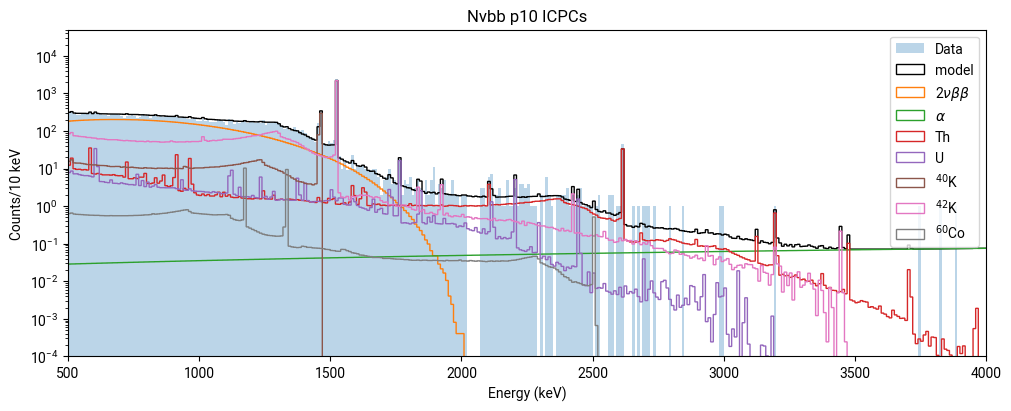

In [52]:
## All bckgs for ICPCs

a_chain    = None
Th_chain   = None
U_chain    = None
K40_chain  = None
K42_chain  = None
Co60_chain = None
for key in [key for key in hfile.keys() if key.startswith('l200a_neutrino24_p10_fix_v2_1_0_a_icpc/origi')][1:]:
    sel_hist = hfile[key].to_hist()
    key_label = key.split('/')[-1][:-2]
    if key_label.startswith('alpha_icpc'):
        if a_chain == None:
            a_chain = sel_hist.copy()
        else:
            a_chain += sel_hist
    elif key_label.startswith('Ac228') or key_label.startswith('Bi212Tl208'):
        if Th_chain == None:
            Th_chain = sel_hist.copy()
        else:
            Th_chain += sel_hist
    elif key_label.startswith('Pb214Bi214'):
        if U_chain == None:
            U_chain = sel_hist.copy()
        else:
            U_chain += sel_hist
    elif key_label.startswith('K40'):
        if K40_chain == None:
            K40_chain = sel_hist.copy()
        else:
            K40_chain += sel_hist
    elif key_label.startswith('K42'):
        if K42_chain == None:
            K42_chain = sel_hist.copy()
        else:
            K42_chain += sel_hist
    elif key_label.startswith('Co60'):
        if Co60_chain == None:
            Co60_chain = sel_hist.copy()
        else:
            Co60_chain += sel_hist
hist_all  = hfile['l200a_neutrino24_p10_fix_v2_1_0_a_icpc/originals/fitted_data;1'].to_hist()
model_all = hfile['l200a_neutrino24_p10_fix_v2_1_0_a_icpc/originals/total_model;1'].to_hist()
Nvbb      = hfile['l200a_neutrino24_p10_fix_v2_1_0_a_icpc/originals/Nvbb_icpc;1']  .to_hist()

c_rebin_fitted_data, be_rebin_fitted_data = rebinned_hist_vals(hist_all)
c_rebin_model      , be_rebin_model       = rebinned_hist_vals(model_all)
c_rebin_Nvbb       , be_rebin_Nvbb        = rebinned_hist_vals(Nvbb)
c_rebin_a_chain    , be_rebin_a_chain     = rebinned_hist_vals(a_chain)
c_rebin_Th_chain   , be_rebin_Th_chain    = rebinned_hist_vals(Th_chain)
c_rebin_U_chain    , be_rebin_U_chain     = rebinned_hist_vals(U_chain)
c_rebin_K40_chain  , be_rebin_K40_chain   = rebinned_hist_vals(K40_chain)
c_rebin_K42_chain  , be_rebin_K42_chain   = rebinned_hist_vals(K42_chain)
c_rebin_Co60_chain , be_rebin_Co60_chain  = rebinned_hist_vals(Co60_chain)

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(be_rebin_fitted_data[:-1], bins=be_rebin_fitted_data, weights=c_rebin_fitted_data, label=f'Data',             alpha=0.3)
ax.hist(be_rebin_model      [:-1], bins=be_rebin_model      , weights=c_rebin_model      , label=f'model',            histtype='step', color='k')
ax.hist(be_rebin_Nvbb       [:-1], bins=be_rebin_Nvbb       , weights=c_rebin_Nvbb       , label=r'2$\nu\beta\beta$', histtype='step')
ax.hist(be_rebin_a_chain    [:-1], bins=be_rebin_a_chain    , weights=c_rebin_a_chain    , label=r'$\alpha$',         histtype='step')
ax.hist(be_rebin_Th_chain   [:-1], bins=be_rebin_Th_chain   , weights=c_rebin_Th_chain   , label=f'Th',               histtype='step')
ax.hist(be_rebin_U_chain    [:-1], bins=be_rebin_U_chain    , weights=c_rebin_U_chain    , label=f'U',                histtype='step')
ax.hist(be_rebin_K40_chain  [:-1], bins=be_rebin_K40_chain  , weights=c_rebin_K40_chain  , label=r'$^{40}$K',         histtype='step')
ax.hist(be_rebin_K42_chain  [:-1], bins=be_rebin_K42_chain  , weights=c_rebin_K42_chain  , label=r'$^{42}$K',         histtype='step')
ax.hist(be_rebin_Co60_chain [:-1], bins=be_rebin_Co60_chain , weights=c_rebin_Co60_chain , label=r'$^{60}$Co',        histtype='step')
plt.xlim(500, 4000)
plt.ylim(1e-4, 5e4)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts/10 keV')
plt.title('Nvbb p10 ICPCs')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

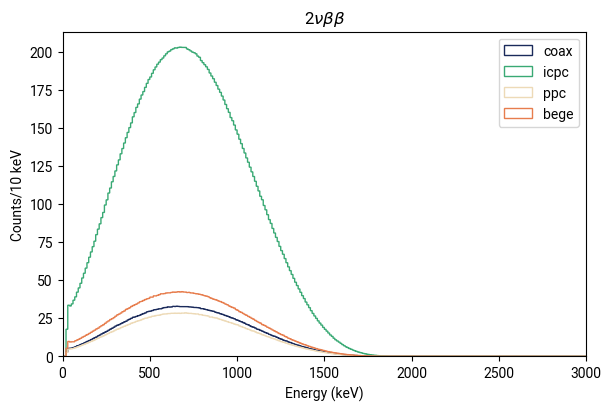

In [53]:
fig, ax = plt.subplots(figsize=(6, 4))

for det_type, col in zip(df_skm.geds_type.unique(), colors_per[1:]):
    Nvbb = hfile[f'l200a_neutrino24_p10_fix_v2_1_0_a_{det_type}/originals/Nvbb_{det_type};1'].to_hist()
    c_rebin_Nvbb, be_rebin_Nvbb = rebinned_hist_vals(Nvbb)
    ax.hist(be_rebin_Nvbb[:-1], bins=be_rebin_Nvbb, weights=c_rebin_Nvbb, label=f'{det_type}', histtype='step', color=legend_colors[col])
plt.xlim(0, 3000)
#plt.ylim(1e-4, 5e4)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts/10 keV')
plt.title(r'2$\nu\beta\beta$')
#plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

## Make a txt file for Lars

In [34]:
def txt_file_with_hist_info(hist, txt_out):

    counts      = hist.values()      # Get the counts (y-values)
    bin_edges   = hist.axes[0].edges # Get the bin edges (x-values)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    with open(txt_out, 'w') as f:
        f.write("BinCenter(keV),Count\n")
        for center, count in zip(bin_centers, counts):
            f.write(f"{center},{count}\n")

In [97]:
## All bckgs for ICPCs

a_chain    = None
Th_chain   = None
U_chain    = None
K40_chain  = None
K42_chain  = None
Co60_chain = None
for key in [key for key in hfile.keys() if key.startswith('l200a_neutrino24_fix_v2_1_0_a_icpc/origi')][1:]:
    sel_hist = hfile[key].to_hist()
    key_label = key.split('/')[-1][:-2]
    if key_label.startswith('alpha_icpc'):
        if a_chain == None:
            a_chain = sel_hist.copy()
        else:
            a_chain += sel_hist
    elif key_label.startswith('Ac228') or key_label.startswith('Bi212Tl208'):
        if Th_chain == None:
            Th_chain = sel_hist.copy()
        else:
            Th_chain += sel_hist
    elif key_label.startswith('Pb214Bi214'):
        if U_chain == None:
            U_chain = sel_hist.copy()
        else:
            U_chain += sel_hist
    elif key_label.startswith('K40'):
        if K40_chain == None:
            K40_chain = sel_hist.copy()
        else:
            K40_chain += sel_hist
    elif key_label.startswith('K42'):
        if K42_chain == None:
            K42_chain = sel_hist.copy()
        else:
            K42_chain += sel_hist
    elif key_label.startswith('Co60'):
        if Co60_chain == None:
            Co60_chain = sel_hist.copy()
        else:
            Co60_chain += sel_hist
hist_all  = hfile['l200a_neutrino24_fix_v2_1_0_a_icpc/originals/fitted_data;1'].to_hist()
model_all = hfile['l200a_neutrino24_fix_v2_1_0_a_icpc/originals/total_model;1'].to_hist()
Nvbb      = hfile['l200a_neutrino24_fix_v2_1_0_a_icpc/originals/Nvbb_icpc;1']  .to_hist()

txt_data_path   = '/Users/romoluque_c/LEGEND/2nbb_distortions/data_bckg_model/'

txt_file_with_hist_info(hist_all  , txt_data_path + 'l200_p03_to_p09_icpc_fitted_data.txt')
txt_file_with_hist_info(model_all , txt_data_path + 'l200_p03_to_p09_icpc_total_model.txt')
txt_file_with_hist_info(Nvbb      , txt_data_path + 'l200_p03_to_p09_icpc_Nvbb.txt')
txt_file_with_hist_info(a_chain   , txt_data_path + 'l200_p03_to_p09_icpc_alphas.txt')
txt_file_with_hist_info(Th_chain  , txt_data_path + 'l200_p03_to_p09_icpc_Th_chain.txt')
txt_file_with_hist_info(U_chain   , txt_data_path + 'l200_p03_to_p09_icpc_U_chain.txt')
txt_file_with_hist_info(K40_chain , txt_data_path + 'l200_p03_to_p09_icpc_K40_chain.txt')
txt_file_with_hist_info(K42_chain , txt_data_path + 'l200_p03_to_p09_icpc_K42_chain.txt')
txt_file_with_hist_info(Co60_chain, txt_data_path + 'l200_p03_to_p09_icpc_Co60_chain.txt')

## Join data for all detector types

In [91]:
## All bckgs for all detectors

a_chain    = None
Th_chain   = None
U_chain    = None
K40_chain  = None
K42_chain  = None
Co60_chain = None
hist_all   = None
model_all  = None
Nvbb_all   = None
for det_type in ['icpc', 'coax', 'ppc', 'bege']:
    for key in [key for key in hfile.keys() if key.startswith(f'l200a_neutrino24_fix_v2_1_0_a_{det_type}/origi')][1:]:
        sel_hist  = hfile[key].to_hist()
        key_label = key.split('/')[-1][:-2]
        if key_label.startswith('alpha'):
            if a_chain == None:
                a_chain = sel_hist.copy()
            else:
                a_chain += sel_hist
        elif key_label.startswith('Ac228') or key_label.startswith('Bi212Tl208'):
            if Th_chain == None:
                Th_chain = sel_hist.copy()
            else:
                Th_chain += sel_hist
        elif key_label.startswith('Pb214Bi214'):
            if U_chain == None:
                U_chain = sel_hist.copy()
            else:
                U_chain += sel_hist
        elif key_label.startswith('K40'):
            if K40_chain == None:
                K40_chain = sel_hist.copy()
            else:
                K40_chain += sel_hist
        elif key_label.startswith('K42'):
            if K42_chain == None:
                K42_chain = sel_hist.copy()
            else:
                K42_chain += sel_hist
        elif key_label.startswith('Co60'):
            if Co60_chain == None:
                Co60_chain = sel_hist.copy()
            else:
                Co60_chain += sel_hist
        elif key_label.startswith('fitted_data'):
            if hist_all == None:
                hist_all = sel_hist.copy()
            else:
                hist_all += sel_hist
        elif key_label.startswith('total_model'):
            if model_all == None:
                model_all = sel_hist.copy()
            else:
                model_all += sel_hist
        elif key_label.startswith('Nvbb'):
            if Nvbb_all == None:
                Nvbb_all = sel_hist.copy()
            else:
                Nvbb_all += sel_hist

txt_data_path = '/Users/romoluque_c/LEGEND/2nbb_distortions/data_bckg_model/'

txt_file_with_hist_info(hist_all  , txt_data_path + 'l200_p03_to_p09_all_det_fitted_data.txt')
txt_file_with_hist_info(model_all , txt_data_path + 'l200_p03_to_p09_all_det_total_model.txt')
txt_file_with_hist_info(Nvbb_all  , txt_data_path + 'l200_p03_to_p09_all_det_Nvbb.txt')
txt_file_with_hist_info(a_chain   , txt_data_path + 'l200_p03_to_p09_all_det_alphas.txt')
txt_file_with_hist_info(Th_chain  , txt_data_path + 'l200_p03_to_p09_all_det_Th_chain.txt')
txt_file_with_hist_info(U_chain   , txt_data_path + 'l200_p03_to_p09_all_det_U_chain.txt')
txt_file_with_hist_info(K40_chain , txt_data_path + 'l200_p03_to_p09_all_det_K40_chain.txt')
txt_file_with_hist_info(K42_chain , txt_data_path + 'l200_p03_to_p09_all_det_K42_chain.txt')
txt_file_with_hist_info(Co60_chain, txt_data_path + 'l200_p03_to_p09_all_det_Co60_chain.txt')

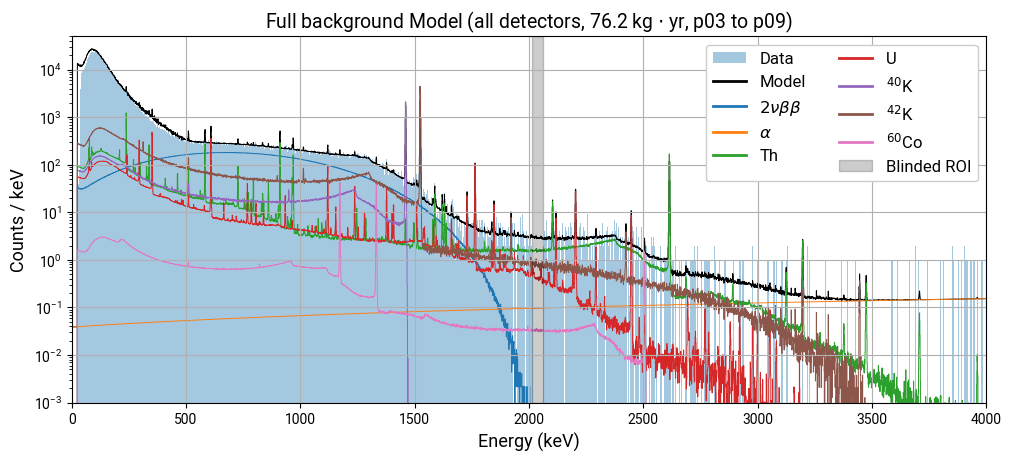

In [102]:
fig, ax = plt.subplots(figsize=(10, 4.5))
ax.bar(hist_all.axes[0].edges[:-1], hist_all.values(), width=np.diff(hist_all.axes[0].edges), align='edge', label='Data', alpha=0.4)
model_all .plot(ax=ax, **style, label='Model', color='black')
Nvbb_all  .plot(ax=ax, **style, label=r'$2\nu\beta\beta$')
a_chain   .plot(ax=ax, **style, label=r'$\alpha$')
Th_chain  .plot(ax=ax, **style, label=r'Th')
U_chain   .plot(ax=ax, **style, label=r'U')
K40_chain .plot(ax=ax, **style, label=r'$^{40}$K')
K42_chain .plot(ax=ax, **style, label=r'$^{42}$K')
Co60_chain.plot(ax=ax, **style, label=r'$^{60}$Co')

# Shade blinded ROI
qbb      = 2039 # keV
roi_ampl =   50 # keV
ax.axvspan(qbb - roi_ampl/2, (qbb + roi_ampl/2)-1, label=r'Blinded ROI', alpha=0.2, color='black')

handles, labels = ax.get_legend_handles_labels()
custom_order    = ['Data', 'Model', r'$2\nu\beta\beta$', r'$\alpha$', r'Th', r'U', r'$^{40}$K', r'$^{42}$K', r'$^{60}$Co', 'Blinded ROI']
ordered_handles = [handles[labels.index(label)] for label in custom_order]
ordered_labels  = [labels [labels.index(label)] for label in custom_order]

leg = ax.legend(ordered_handles, ordered_labels, loc='upper right', ncol=2, framealpha=1, fontsize=12)
for line in leg.get_lines():
    line.set_linewidth(2)
ax.set_yscale('log')

# From Neutrino2024 talk
L200_data_exposure = 76.2 #kg * yr

ax.set_title(f'Full background Model (all detectors, {L200_data_exposure}'+ r' kg $\cdot$ yr, p03 to p09)', fontsize=14)
ax.set_ylabel('Counts / keV', fontsize=13)
ax.set_xlabel('Energy (keV)', fontsize=13)
ax.set_ylim(1e-3, 5e4)
ax.set_xlim(0, 4000)
ax.grid()
#fig.savefig('./images/L200_bckg_model_all_detectors.pdf', bbox_inches='tight')
plt.show()

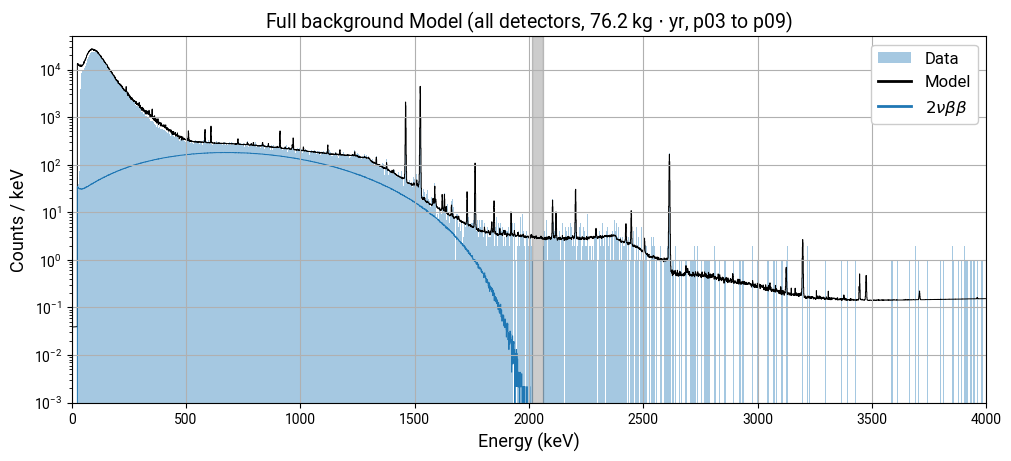

In [101]:
fig, ax = plt.subplots(figsize=(10, 4.5))
ax.bar(hist_all.axes[0].edges[:-1], hist_all.values(), width=np.diff(hist_all.axes[0].edges), align='edge', label='Data', alpha=0.4)
model_all .plot(ax=ax, **style, label='Model', color='black')
Nvbb_all  .plot(ax=ax, **style, label=r'$2\nu\beta\beta$')

# Shade blinded ROI
qbb      = 2039 # keV
roi_ampl =   50 # keV
ax.axvspan(qbb - roi_ampl/2, (qbb + roi_ampl/2)-1, label=r'Blinded ROI', alpha=0.2, color='black')

handles, labels = ax.get_legend_handles_labels()
custom_order    = ['Data', 'Model', r'$2\nu\beta\beta$']
ordered_handles = [handles[labels.index(label)] for label in custom_order]
ordered_labels  = [labels [labels.index(label)] for label in custom_order]

leg = ax.legend(ordered_handles, ordered_labels, loc='upper right', ncol=1, framealpha=1, fontsize=12)
for line in leg.get_lines():
    line.set_linewidth(2)
ax.set_yscale('log')

# From Neutrino2024 talk
L200_data_exposure = 76.2 #kg * yr

ax.set_title(f'Full background Model (all detectors, {L200_data_exposure}'+ r' kg $\cdot$ yr, p03 to p09)', fontsize=14)
ax.set_ylabel('Counts / keV', fontsize=13)
ax.set_xlabel('Energy (keV)', fontsize=13)
ax.set_ylim(1e-3, 5e4)
ax.set_xlim(0, 4000)
ax.grid()
#fig.savefig('./images/L200_bckg_model_all_detectors_2nbb.pdf', bbox_inches='tight')
plt.show()